# Data collection and preprocessing

## Load data from hf

In [1]:
from datasets import load_dataset

# load only validation dataset of python
dataset = load_dataset("code_search_net", "python", split="validation")
print(dataset)
# print(dataset[0]['whole_func_string'])
# print(dataset[0]['func_code_string'])
# print(dataset[0]['func_documentation_string'])

Dataset({
    features: ['repository_name', 'func_path_in_repository', 'func_name', 'whole_func_string', 'language', 'func_code_string', 'func_code_tokens', 'func_documentation_string', 'func_documentation_tokens', 'split_name', 'func_code_url'],
    num_rows: 23107
})


## Convert the dataset into pairs of docstring-code

In [250]:
pair_tokens = [(d['func_documentation_tokens'], d['func_code_tokens']) for d in dataset]

# convert tokens back to strings because we have to use roberta tokenizer
pair_tokens = [(" ".join(doc), " ".join(code)) for doc, code in pair_tokens]

# filter out pairs with documentation or code longer than LIMIT
LIMIT = 512
pair_tokens = [pair_token for pair_token in pair_tokens if len(pair_token[0]) <= LIMIT and len(pair_token[1]) <=LIMIT]

len(pair_tokens)

14678

## Cross-encode doc-code pairs using RoBERTa

In [252]:
from transformers.models.roberta import RobertaTokenizer

tnizer = RobertaTokenizer.from_pretrained("microsoft/codebert-base")

# setting max_length because model expects fixed length inputs
encoded_inputs = tnizer(pair_tokens[:20], padding="max_length", truncation=True, max_length=256, return_tensors="pt")

"<s>Stack of fully - connected layers to be used in a policy / q - function approximator</s></s>def mlp ( num_layers = 2 , num_hidden = 64 , activation = tf . tanh , layer_norm = False ) : def network_fn ( X ) : h = tf . layers . flatten ( X ) for i in range ( num_layers ) : h = fc ( h , 'mlp_fc{}' . format ( i ) , nh = num_hidden , init_scale = np . sqrt ( 2 ) ) if layer_norm : h = tf . contrib . layers . layer_norm ( h , center = True , scale = True ) h = activation ( h ) return h return network_fn</s><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad>"

In [204]:
# Init model
from transformers.models.roberta import RobertaModel

# Using roberta because codebert is built on top of it (roberta has the same architecture as bert, the only difference is that it is trained on much more data, and NSP task is skipped while training).
model = RobertaModel.from_pretrained("microsoft/codebert-base", output_attentions=True, attn_implementation="eager")
model.eval()

RobertaModel(
  (embeddings): RobertaEmbeddings(
    (word_embeddings): Embedding(50265, 768, padding_idx=1)
    (position_embeddings): Embedding(514, 768, padding_idx=1)
    (token_type_embeddings): Embedding(1, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): RobertaEncoder(
    (layer): ModuleList(
      (0-11): 12 x RobertaLayer(
        (attention): RobertaAttention(
          (self): RobertaSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): RobertaSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
            (dropou

In [247]:
import torch
with torch.no_grad():
    outputs = model(**encoded_inputs)

# This is a tuple of (layer1, layer2, ..., layer12), each shape: [1, num_heads, seq_len, seq_len]
# attentions[layer][batch][head] -> 2d array representing attention scores
print(outputs.attentions[0][0][0].sum()) # attention scores of first attention head in first layer of first sequence

tensor(256.0000)


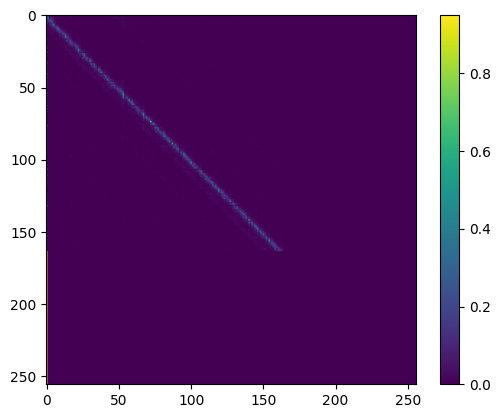

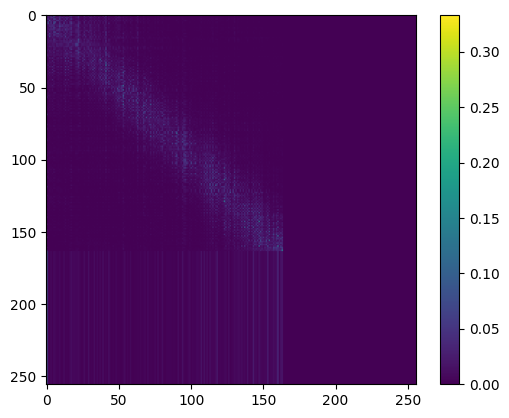

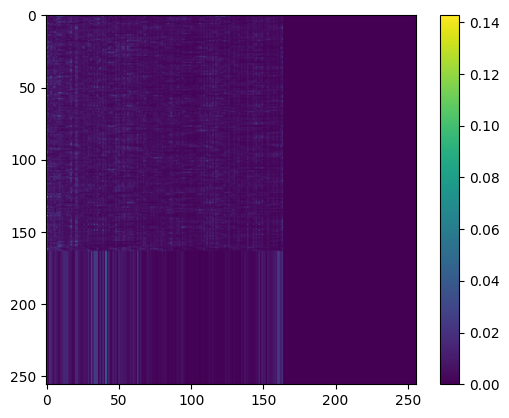

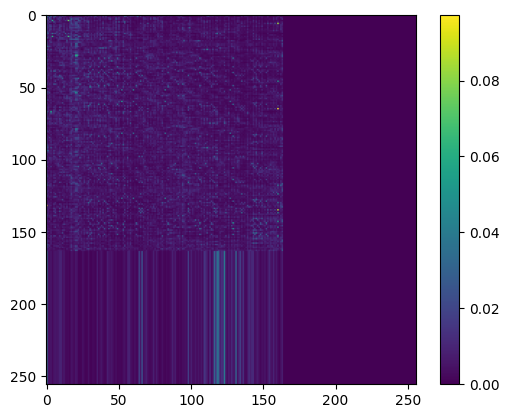

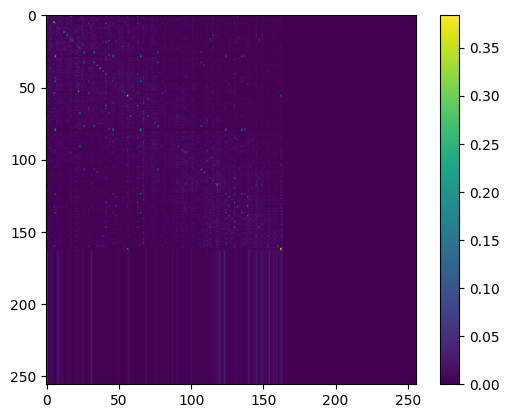

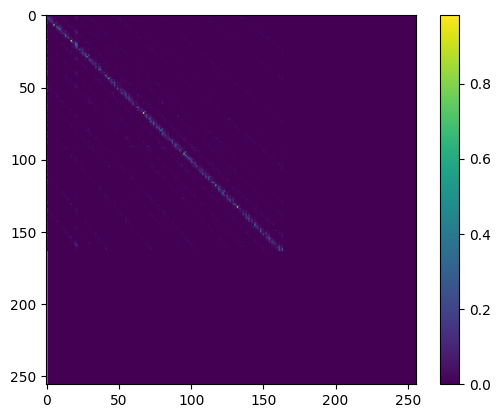

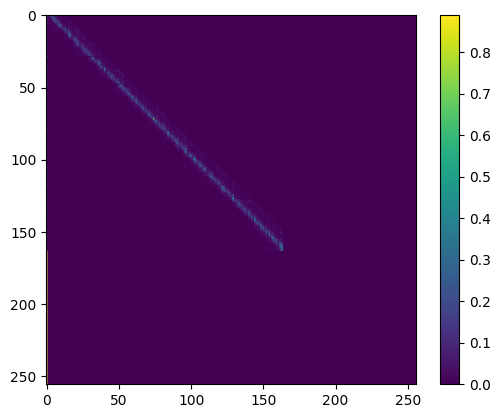

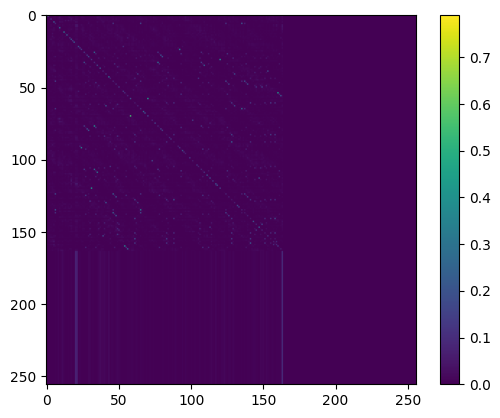

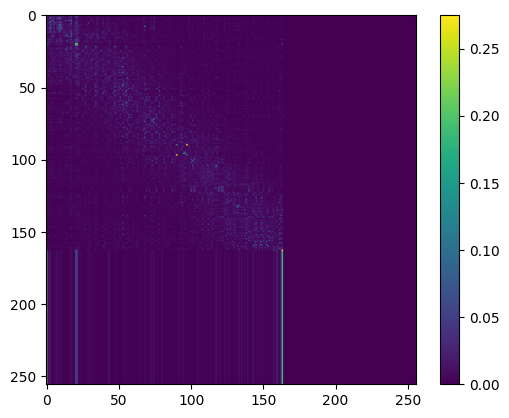

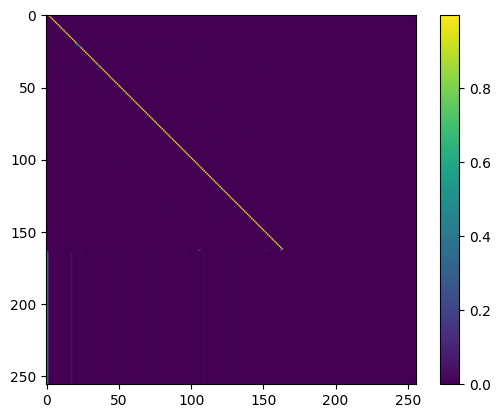

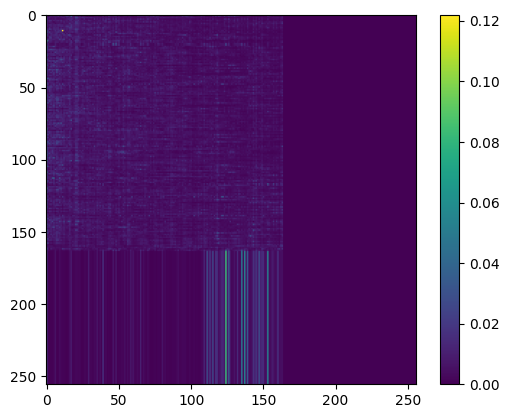

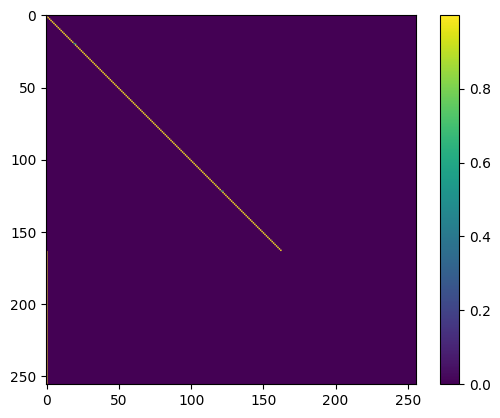

In [248]:
import matplotlib.pyplot as plt

# Visualize it
for i in range(12):
    plt.imshow(outputs.attentions[0][0][i], cmap='viridis')  # or 'gray', 'hot', 'jet', etc.
    plt.colorbar()  
    plt.show()